# Credit Card Fraud Detection 


In [1]:
!pip install -q imbalanced-learn xgboost

## 1. Imports & Global Config

In [2]:
import os
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    roc_curve,
    roc_auc_score,
    precision_recall_curve,
    average_precision_score,
    f1_score,
    precision_score,
    recall_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC


try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except Exception as e:
    XGB_AVAILABLE = False
    print("xgboost not found")

# Resampling (imbalanced-learn)
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.under_sampling import RandomUnderSampler
    from imblearn.pipeline import Pipeline as ImbPipeline
    IMB_AVAILABLE = True
except Exception as e:
    IMB_AVAILABLE = False
    print("imbalanced-learn not found; SMOTE/undersampling steps will be skipped unless installed.")

# Reproducibility
SEED = 42
np.random.seed(SEED)


## 2. Data Loading

In [3]:

DATA_PATH = "creditcard.csv"

if not os.path.exists(DATA_PATH):
    raise FileNotFoundError(
        f"Could not find the dataset at {DATA_PATH}. "
    )

df = pd.read_csv(DATA_PATH)
print("Shape:", df.shape)
df.head()


Shape: (284807, 31)


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


### 2.1 Basic Info

In [4]:

print("Columns:", df.columns.tolist())
print("\nData Types / Non-Nulls:")
print(df.info())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDescriptive statistics (numeric):")
df.describe()


Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Data Types / Non-Nulls:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  fl

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000



## 3. Exploratory Data Analysis (EDA)

### 3.1 Class Imbalance


In [5]:
class_counts = df['Class'].value_counts().sort_index()
print("Class counts (0 = non-fraud, 1 = fraud):")
print(class_counts)
print("\nFraud rate: {:.5f}%".format(class_counts.get(1,0) / class_counts.sum() * 100))

Class counts (0 = non-fraud, 1 = fraud):
Class
0    284315
1       492
Name: count, dtype: int64

Fraud rate: 0.17275%


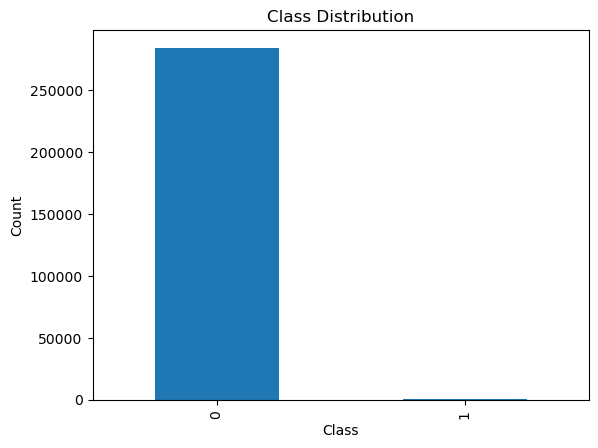

In [6]:
# Bar plot
plt.figure()
class_counts.plot(kind='bar')
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

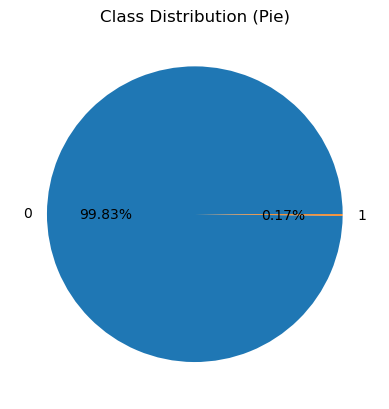

In [7]:
# Pie chart
plt.figure()
plt.pie(class_counts.values, labels=class_counts.index.astype(str), autopct='%1.2f%%')
plt.title("Class Distribution (Pie)")
plt.show()


### 3.2 Distributions of Key Features (e.g., Amount, Time) by Class

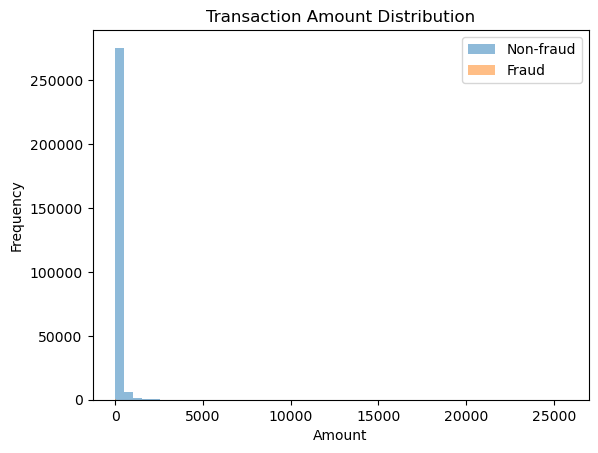

In [8]:
amount_fraud = df.loc[df['Class'] == 1, 'Amount']
amount_nonfraud = df.loc[df['Class'] == 0, 'Amount']

plt.figure()
plt.hist(amount_nonfraud, bins=50, alpha=0.5, label='Non-fraud')
plt.hist(amount_fraud, bins=50, alpha=0.5, label='Fraud')
plt.title("Transaction Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.legend()
plt.show()

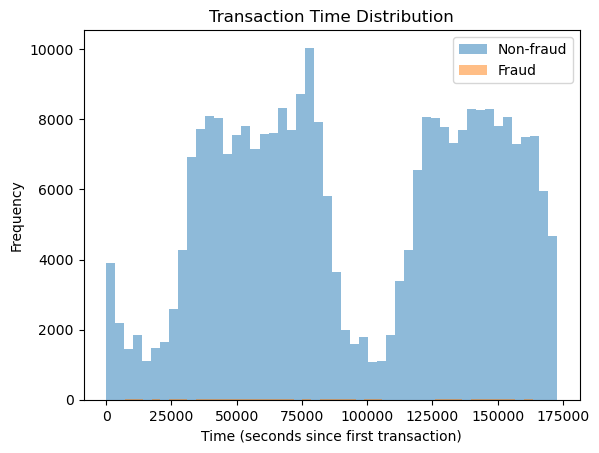

In [9]:
if 'Time' in df.columns:
    plt.figure()
    plt.hist(df.loc[df['Class']==0, 'Time'], bins=50, alpha=0.5, label='Non-fraud')
    plt.hist(df.loc[df['Class']==1, 'Time'], bins=50, alpha=0.5, label='Fraud')
    plt.title("Transaction Time Distribution")
    plt.xlabel("Time (seconds since first transaction)")
    plt.ylabel("Frequency")
    plt.legend()
    plt.show()


### 3.3 Correlations

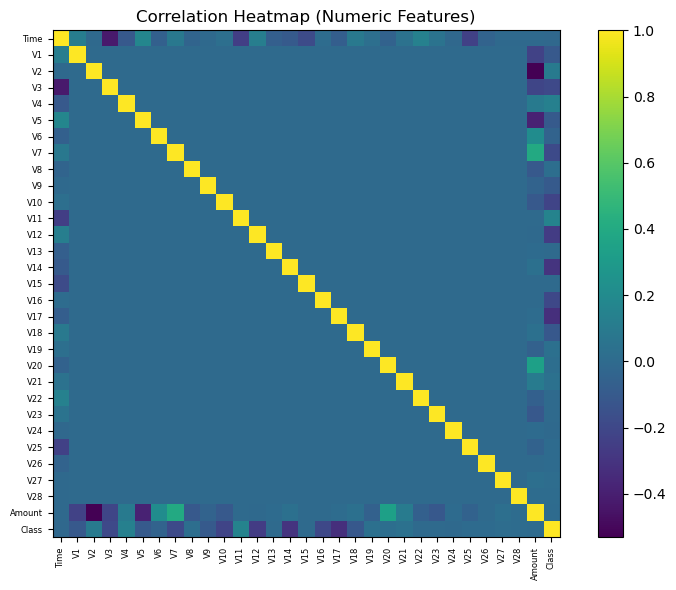

In [10]:
# Correlation matrix (numeric only)
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize=(8, 6))
plt.imshow(corr, interpolation='nearest')
plt.title("Correlation Heatmap (Numeric Features)")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.tight_layout()
plt.show()

In [11]:
# Correlation with Class
if 'Class' in corr.columns:
    corr_with_class = corr['Class'].drop('Class').sort_values(ascending=False)
    print("Top features correlated with Class (absolute):")
    print(corr_with_class.abs().sort_values(ascending=False).head(15))


Top features correlated with Class (absolute):
V17    0.326481
V14    0.302544
V12    0.260593
V10    0.216883
V16    0.196539
V3     0.192961
V7     0.187257
V11    0.154876
V4     0.133447
V18    0.111485
V1     0.101347
V9     0.097733
V5     0.094974
V2     0.091289
V6     0.043643
Name: Class, dtype: float64



## 4. Data Preprocessing


In [12]:
# Features/target
X = df.drop(columns=['Class'])
y = df['Class'].astype(int)

# Train/test split (stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

numeric_cols = X_train.columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols)
    ],
    remainder="drop"
)


## 5. Helper Functions (Evaluation & Plots)

In [13]:

def evaluate_model(clf, X_test, y_test, model_name="Model"):
    if hasattr(clf, "predict_proba"):
        y_proba = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        y_proba = clf.decision_function(X_test)
    else:
        y_proba = None

    y_pred = clf.predict(X_test)

    cm = confusion_matrix(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba) if y_proba is not None else np.nan
    pr_auc = average_precision_score(y_test, y_proba) if y_proba is not None else np.nan
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)

    print(f"=== {model_name} ===")
    print("Confusion Matrix:\n", cm)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, digits=4, zero_division=0))
    print(f"ROC-AUC: {roc_auc:.5f}")
    print(f"PR-AUC (Average Precision): {pr_auc:.5f}")
    print(f"Precision: {prec:.5f} | Recall: {rec:.5f} | F1: {f1:.5f}\n")

    return {
        "model": model_name,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision": prec,
        "recall": rec,
        "f1": f1
    }

def plot_roc_curves(models, X_test, y_test):
    plt.figure()
    for name, clf in models.items():
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_proba = clf.decision_function(X_test)
        else:
            y_proba = None

        if y_proba is not None:
            fpr, tpr, _ = roc_curve(y_test, y_proba)
            plt.plot(fpr, tpr, label=name)
    plt.plot([0,1],[0,1],'--')
    plt.title("ROC Curves")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show()

def plot_pr_curves(models, X_test, y_test):
    plt.figure()
    for name, clf in models.items():
        if hasattr(clf, "predict_proba"):
            y_proba = clf.predict_proba(X_test)[:, 1]
        elif hasattr(clf, "decision_function"):
            y_proba = clf.decision_function(X_test)
        else:
            y_proba = None

        if y_proba is not None:
            precision, recall, _ = precision_recall_curve(y_test, y_proba)
            plt.plot(recall, precision, label=name)
    plt.title("Precision-Recall Curves")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.show()


## 6. Baseline Models

In [14]:
baseline_models = {}

# Logistic Regression
log_reg = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", LogisticRegression(max_iter=1000, random_state=SEED))
])
log_reg.fit(X_train, y_train)
baseline_models["LogReg"] = log_reg

In [15]:
# Decision Tree
dt = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", DecisionTreeClassifier(random_state=SEED))
])
dt.fit(X_train, y_train)
baseline_models["DecisionTree"] = dt

In [16]:
# Random Forest
rf = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1))
])
rf.fit(X_train, y_train)
baseline_models["RandomForest"] = rf


In [17]:
# SVM 
svm = Pipeline(steps=[
    ("pre", preprocessor),
    ("clf", SVC(kernel="rbf", probability=True, random_state=SEED))
])
svm.fit(X_train, y_train)
baseline_models["SVM"] = svm


In [18]:
# XGBoost
if XGB_AVAILABLE:
    # Compute scale_pos_weight = (#neg / #pos) to help with imbalance
    pos = y_train.sum()
    neg = len(y_train) - pos
    spw = max(1.0, neg / max(1, pos))

    xgb = Pipeline(steps=[
        ("pre", preprocessor),
        ("clf", XGBClassifier(
            n_estimators=500,
            max_depth=5,
            learning_rate=0.05,
            subsample=0.9,
            colsample_bytree=0.9,
            reg_lambda=1.0,
            objective="binary:logistic",
            eval_metric="logloss",
            tree_method="hist",
            random_state=SEED,
            scale_pos_weight=spw
        ))
    ])
    xgb.fit(X_train, y_train)
    baseline_models["XGBoost"] = xgb


### 6.1 Evaluate Baselines

In [19]:

baseline_results = []
for name, model in baseline_models.items():
    res = evaluate_model(model, X_test, y_test, model_name=name)
    baseline_results.append(res)

baseline_df = pd.DataFrame(baseline_results).sort_values("pr_auc", ascending=False)
baseline_df


=== LogReg ===
Confusion Matrix:
 [[56851    13]
 [   36    62]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9994    0.9998    0.9996     56864
           1     0.8267    0.6327    0.7168        98

    accuracy                         0.9991     56962
   macro avg     0.9130    0.8162    0.8582     56962
weighted avg     0.9991    0.9991    0.9991     56962

ROC-AUC: 0.96055
PR-AUC (Average Precision): 0.74138
Precision: 0.82667 | Recall: 0.63265 | F1: 0.71676

=== DecisionTree ===
Confusion Matrix:
 [[56840    24]
 [   25    73]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9996    0.9996    0.9996     56864
           1     0.7526    0.7449    0.7487        98

    accuracy                         0.9991     56962
   macro avg     0.8761    0.8722    0.8741     56962
weighted avg     0.9991    0.9991    0.9991     56962

ROC-AUC: 0.87224
PR-AUC (Average Precision): 0.56103
Prec

,model,roc_auc,pr_auc,precision,recall,f1
4,XGBoost,0.979183,0.879091,0.861702,0.826531,0.843750
2,RandomForest,0.961741,0.869852,0.941860,0.826531,0.880435
3,SVM,0.968111,0.855161,0.957746,0.693878,0.804734
0,LogReg,0.960549,0.741382,0.826667,0.632653,0.716763
1,DecisionTree,0.872238,0.561032,0.752577,0.744898,0.748718


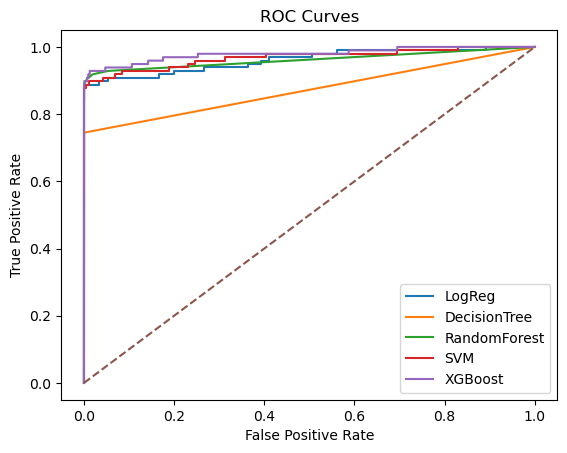

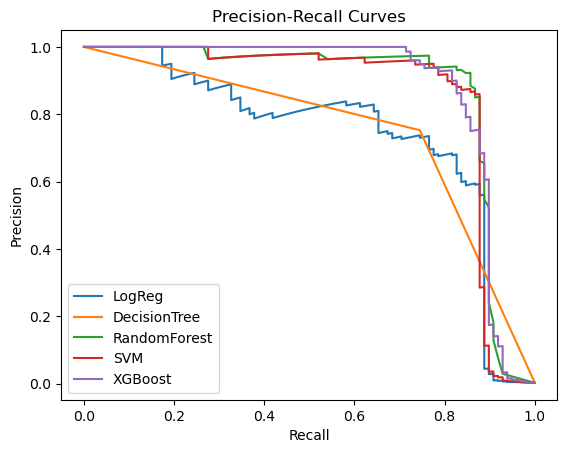

In [20]:
# Plot ROC & PR curves
plot_roc_curves(baseline_models, X_test, y_test)
plot_pr_curves(baseline_models, X_test, y_test)



## 7. Model Improvements

### 7.1 Resampling


In [21]:

improved_models = {}

if IMB_AVAILABLE:
    # SMOTE + Logistic Regression
    smote_logreg = ImbPipeline(steps=[
        ("pre", preprocessor),
        ("smote", SMOTE(random_state=SEED)),
        ("clf", LogisticRegression(max_iter=1000, random_state=SEED))
    ])
    smote_logreg.fit(X_train, y_train)
    improved_models["SMOTE+LogReg"] = smote_logreg

    # Undersampling + RandomForest
    under_rf = ImbPipeline(steps=[
        ("pre", preprocessor),
        ("under", RandomUnderSampler(random_state=SEED)),
        ("clf", RandomForestClassifier(n_estimators=300, random_state=SEED, n_jobs=-1))
    ])
    under_rf.fit(X_train, y_train)
    improved_models["UnderSample+RF"] = under_rf
else:
    print("Resampling skipped; install imbalanced-learn to enable.")


C:\Users\DuaaHilal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\DuaaHilal\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
        "wmic CPU Get NumberOfCores /Format:csv".split(),
        capture_output=True,
        text=True,
    )
  File "C:\Users\DuaaHilal\anaconda3\Lib\subprocess.py", line 554, in run
    with Popen(*popenargs, **kwargs) as process:
         ~~~~~^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\DuaaHilal\anaconda3\Lib\subprocess.py", line 1039, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
    ~~~~~~~~~~~~~~~~~~~^^

In [22]:

improved_results = []
for name, model in improved_models.items():
    res = evaluate_model(model, X_test, y_test, model_name=name)
    improved_results.append(res)

improved_df = pd.DataFrame(improved_results).sort_values("pr_auc", ascending=False) if improved_results else pd.DataFrame()
improved_df


=== SMOTE+LogReg ===
Confusion Matrix:
 [[55397  1467]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9742    0.9869     56864
           1     0.0578    0.9184    0.1088        98

    accuracy                         0.9741     56962
   macro avg     0.5288    0.9463    0.5478     56962
weighted avg     0.9982    0.9741    0.9854     56962

ROC-AUC: 0.97084
PR-AUC (Average Precision): 0.72447
Precision: 0.05780 | Recall: 0.91837 | F1: 0.10876

=== UnderSample+RF ===
Confusion Matrix:
 [[54908  1956]
 [    8    90]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9999    0.9656    0.9824     56864
           1     0.0440    0.9184    0.0840        98

    accuracy                         0.9655     56962
   macro avg     0.5219    0.9420    0.5332     56962
weighted avg     0.9982    0.9655    0.9809     56962

ROC-AUC: 0.97608
PR-AUC (Average Precision): 0.68

,model,roc_auc,pr_auc,precision,recall,f1
0,SMOTE+LogReg,0.970843,0.724469,0.057803,0.918367,0.108761
1,UnderSample+RF,0.976076,0.687420,0.043988,0.918367,0.083955


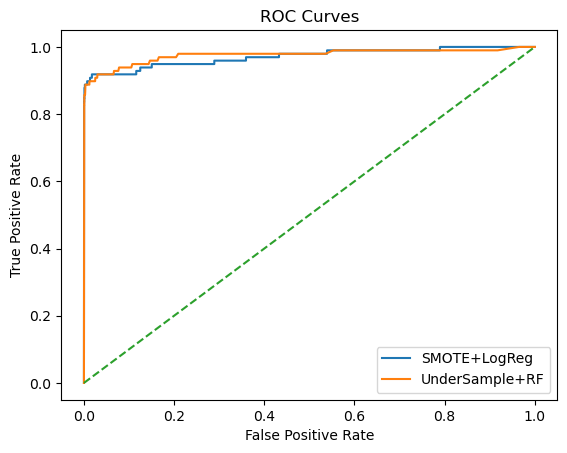

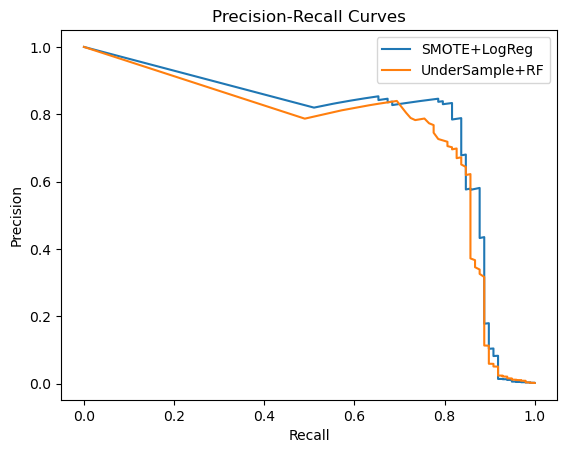

In [23]:

# ROC & PR curves 
if len(improved_models) > 0:
    plot_roc_curves(improved_models, X_test, y_test)
    plot_pr_curves(improved_models, X_test, y_test)



### 7.2 Decision Threshold Adjustment



In [24]:
if "XGBoost" in baseline_models:
    ref_model_name = "XGBoost"
    ref_model = baseline_models["XGBoost"]
elif "SMOTE+LogReg" in improved_models:
    ref_model_name = "SMOTE+LogReg"
    ref_model = improved_models["SMOTE+LogReg"]
else:
    ref_model_name = "LogReg"
    ref_model = baseline_models["LogReg"]

print(f"Tuning threshold for: {ref_model_name}")

# Get probabilities/scores
if hasattr(ref_model, "predict_proba"):
    y_scores = ref_model.predict_proba(X_test)[:, 1]
elif hasattr(ref_model, "decision_function"):
    y_scores = ref_model.decision_function(X_test)
else:
    raise RuntimeError("Selected model does not support probability/score outputs.")

precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)

# Find lowest threshold that gives recall >= target
target_recall = 0.90  # adjust per business need
best_thr = None
for p, r, t in zip(precisions, recalls, np.append(thresholds, 1.0)):
    if r >= target_recall:
        best_thr = t
        break

if best_thr is None:
    best_thr = 0.5  # fallback
    print("Could not achieve target recall with any threshold; using 0.5.")

print(f"Chosen threshold = {best_thr:.5f} to target recall >= {target_recall:.2f}")

# Evaluate at this threshold
y_pred_thr = (y_scores >= best_thr).astype(int)

cm = confusion_matrix(y_test, y_pred_thr)
prec = precision_score(y_test, y_pred_thr, zero_division=0)
rec = recall_score(y_test, y_pred_thr, zero_division=0)
f1 = f1_score(y_test, y_pred_thr, zero_division=0)
pr_auc = average_precision_score(y_test, y_scores)
roc_auc = roc_auc_score(y_test, y_scores)

print("Confusion Matrix at tuned threshold:\n", cm)
print("\nClassification Report (threshold-tuned):")
print(classification_report(y_test, y_pred_thr, digits=4, zero_division=0))
print(f"ROC-AUC: {roc_auc:.5f} | PR-AUC: {pr_auc:.5f}")
print(f"Precision: {prec:.5f} | Recall: {rec:.5f} | F1: {f1:.5f}")




Tuning threshold for: XGBoost
Chosen threshold = 0.00000 to target recall >= 0.90
Confusion Matrix at tuned threshold:
 [[    0 56864]
 [    0    98]]

Classification Report (threshold-tuned):
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000     56864
           1     0.0017    1.0000    0.0034        98

    accuracy                         0.0017     56962
   macro avg     0.0009    0.5000    0.0017     56962
weighted avg     0.0000    0.0017    0.0000     56962

ROC-AUC: 0.97918 | PR-AUC: 0.87909
Precision: 0.00172 | Recall: 1.00000 | F1: 0.00343


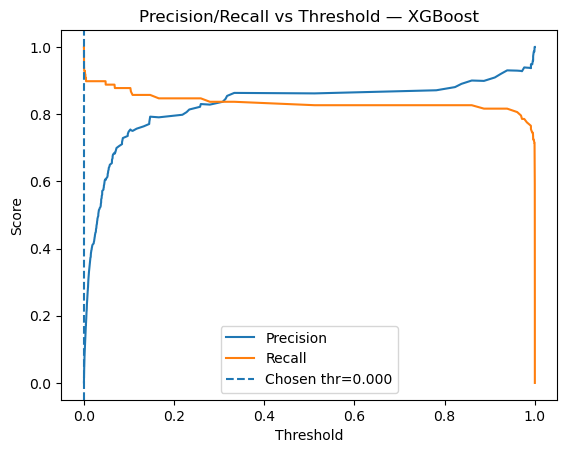

In [25]:
# Plot Precision/Recall vs Threshold
plt.figure()
plt.plot(np.append(thresholds, 1.0), precisions, label="Precision")
plt.plot(np.append(thresholds, 1.0), recalls, label="Recall")
plt.axvline(best_thr, linestyle="--", label=f"Chosen thr={best_thr:.3f}")
plt.title(f"Precision/Recall vs Threshold — {ref_model_name}")
plt.xlabel("Threshold")
plt.ylabel("Score")
plt.legend()
plt.show()


## 8. Summary & Next Steps

- **Why accuracy is misleading:** With extreme imbalance, a model that always predicts *non-fraud* can get >99% accuracy but 0 recall for the fraud class. Favor **recall**, **precision**, **PR-AUC**, and **ROC-AUC**.
- **Trade-offs:**  
  - **High recall** catches more frauds but increases false alarms (lower precision).  
  - **High precision** reduces false alarms but may miss frauds (lower recall).  
- **What helped here:** Resampling (SMOTE/undersampling), class-weighted/tree methods (e.g., XGBoost with `scale_pos_weight`), and **threshold tuning**.

**Possible next steps:**
1. **Cost-sensitive learning:** Incorporate different costs for false negatives vs. false positives.
2. **Ensembles:** Stacking or blending multiple strong models.
3. **Anomaly detection:** One-Class SVM, Isolation Forest, Local Outlier Factor for additional signals.
4. **Temporal features:** Engineer features based on transaction sequences or user profiles.
5. **Calibration:** Calibrate predicted probabilities (e.g., Platt scaling, isotonic regression).


### 8.1 Compare All Results Collected

In [26]:

# Merge baseline and improved result tables if available
summary_df = pd.concat([df for df in [pd.DataFrame(globals().get('baseline_results', [])), pd.DataFrame(globals().get('improved_results', []))] if len(df)>0], ignore_index=True)
if len(summary_df) > 0:
    display(summary_df.sort_values(["pr_auc","roc_auc"], ascending=[False, False]).reset_index(drop=True))
else:
    print("No results captured yet (run previous sections).")


,model,roc_auc,pr_auc,precision,recall,f1
0,XGBoost,0.979183,0.879091,0.861702,0.826531,0.843750
1,RandomForest,0.961741,0.869852,0.941860,0.826531,0.880435
2,SVM,0.968111,0.855161,0.957746,0.693878,0.804734
3,LogReg,0.960549,0.741382,0.826667,0.632653,0.716763
4,SMOTE+LogReg,0.970843,0.724469,0.057803,0.918367,0.108761
5,UnderSample+RF,0.976076,0.687420,0.043988,0.918367,0.083955
6,DecisionTree,0.872238,0.561032,0.752577,0.744898,0.748718
